In [1]:
import json
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path
from glob import glob
from os import path
%matplotlib inline

# Load Benchmark Results

In [2]:
def load_outputs_files(folder_path):
    output_files = glob(path.join(folder_path, '*.json'))
    outputs, failed = [], []

    for file in output_files:
        try:
            json_res = json.load(open(file))
            json_res['name'] = Path(file).stem
            
            outputs.append(json_res)
        except:
            failed.append(path.basename(file))

    return outputs, failed

automaton_outputs, automaton_failed = load_outputs_files('../outputs/outputs-automaton-12.10.2022/')
formula_outputs, formula_failed = load_outputs_files('../outputs/outputs-formula-11.27.2022/')

In [3]:
print(f"Failed Automaton Benchmarks (Total {len(automaton_failed)}): ", automaton_failed)
print(f"Failed Formula Benchmarks (Total {len(formula_failed)}: ", formula_failed)

Failed Automaton Benchmarks (Total 9):  ['10.json', '06.json', '07.json', '11.json', '12.json', '08.json', '09.json', '13.json', '05.json']
Failed Formula Benchmarks (Total 12:  ['10.json', '06.json', '07.json', '11.json', 'KitchenTimerV3.json', '12.json', '08.json', '09.json', '13.json', '05.json', '03.json', 'ltl2dba07.json']


In [4]:
def extract_formula_benchmarks(formula_output):
    total_tested_vars = len(formula_output['tested_variables'])
    total_untested_vars = len(formula_output['output_vars']) - total_tested_vars
    dependent_vars , independent_vars = [], []

    for tested_var in formula_output['tested_variables']:
        if tested_var['is_dependent']:
            dependent_vars.append(tested_var['name'])
        else:
            independent_vars.append(tested_var['name'])

    untested_vars = set(formula_output['output_vars']) - set(dependent_vars) - set(independent_vars)

    return {
        'name': formula_output['name'],
        "is_completed": formula_output['is_completed'],
        "total_duration": formula_output['total_time'],
        
        "is_automaton_built": formula_output['automaton']['is_built'],
        "automaton_build_duration": formula_output['automaton'].get('build_duration', None),
        "automaton_total_states": formula_output['automaton'].get('total_states', None),
        "automaton_state_based": formula_output['automaton'].get('state_based_status', None),
        
        "dependent_vars": dependent_vars,
        "total_dependent_vars": len(dependent_vars),
        
        "independent_vars": independent_vars,
        "total_independent_vars": independent_vars,
        
        "untested_vars": list(untested_vars),
        "total_tested_vars": total_tested_vars,
        "total_untested_vars": total_untested_vars,
        
        "output_vars": formula_output['output_vars'],
        "input_vars": formula_output['input_vars'],
        "formula": formula_output['formula'],
    }

formulas_df = pd.DataFrame([
    extract_formula_benchmarks(formula)
    for formula in formula_outputs
])
formulas_df.set_index("name")
formulas_df.head()

,name,is_completed,total_duration,is_automaton_built,automaton_build_duration,automaton_total_states,automaton_state_based,dependent_vars,total_dependent_vars,independent_vars,total_independent_vars,untested_vars,total_tested_vars,total_untested_vars,output_vars,input_vars,formula
0,ltl2dpa20,False,2399989,True,34.0,14.0,true,[p0],1,[],[],[p1],1,1,"[p1, p0]","[c, b, a]",G((p0 & !p1) | (!p0 & p1)) & ((FG!p0 & (FG!a |...
1,TwoCountersInRangeA2,False,2399993,True,8030.0,6.0,true,[u0first2counter0first2counter],1,[],[],[u0second2counter0f1dincrement0second2counter1...,1,7,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",(!p0p0in2range0first2counter | !p0p0in2range0s...
2,lilydemo24,True,57722,True,21.0,12.0,true,[],0,"[b2s_ack0, b2s_ack1, b2r_req0, b2r_req1]","[b2s_ack0, b2s_ack1, b2r_req0, b2r_req1]",[],4,0,"[b2r_req1, b2r_req0, b2s_ack1, b2s_ack0]","[r2b_ack1, r2b_ack0, s2b_req1, s2b_req0]",r2b_ack0 | F((!b2r_req0 & Xr2b_ack0) | (b2r_re...
3,OneCounterGuiA9,False,2399991,True,16004.0,9.0,true,[u0button2down0button2down],1,[],[],"[u0counter0counter, u0button2down0f1denable1b,...",1,8,"[u0counter0f1dinc0counter1b, u0counter0f1ddec0...","[p0p0in2range0f1dinc0f1dinc0counter1b1b, p0p0i...",(p0p0button2pressed0down | p0p0button2pressed0...
4,ltl2dba24,True,20,True,10.0,4.0,true,[],0,[acc],[acc],[],1,0,[acc],[p],(Fp & GFacc) | (G!p & FG!acc)


In [5]:
def extract_automaton_benchmarks(automaton_output):
    return {
        **extract_formula_benchmarks(automaton_output),
        "total_pair_states": automaton_output['algorithm'].get('total_pair_state', None),
        "search_pair_state_duration": automaton_output['algorithm'].get('search_pair_state_duration', None),
        "pruned_state_based_status": automaton_output['algorithm'].get('pruned_state_based_status', None),
    }

automaton_df = pd.DataFrame([
    extract_automaton_benchmarks(automaton)
    for automaton in automaton_outputs
])
automaton_df.set_index("name")
automaton_df.head()

,name,is_completed,total_duration,is_automaton_built,automaton_build_duration,automaton_total_states,automaton_state_based,dependent_vars,total_dependent_vars,independent_vars,total_independent_vars,untested_vars,total_tested_vars,total_untested_vars,output_vars,input_vars,formula,total_pair_states,search_pair_state_duration,pruned_state_based_status
0,ltl2dpa20,True,35,True,33.0,14.0,true,[p0],1,[p1],[p1],[],2,0,"[p1, p0]","[c, b, a]",G((p0 & !p1) | (!p0 & p1)) & ((FG!p0 & (FG!a |...,27,0.0,true
1,TwoCountersInRangeA2,True,7735,True,7728.0,6.0,true,"[u0first2counter0first2counter, u0second2count...",3,"[u0first2counter0f1ddecrement0first2counter1b,...","[u0first2counter0f1ddecrement0first2counter1b,...",[],8,0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",(!p0p0in2range0first2counter | !p0p0in2range0s...,12,0.0,true
2,lilydemo24,True,22,True,21.0,12.0,true,[],0,"[b2s_ack0, b2s_ack1, b2r_req0, b2r_req1]","[b2s_ack0, b2s_ack1, b2r_req0, b2r_req1]",[],4,0,"[b2r_req1, b2r_req0, b2s_ack1, b2s_ack0]","[r2b_ack1, r2b_ack0, s2b_req1, s2b_req0]",r2b_ack0 | F((!b2r_req0 & Xr2b_ack0) | (b2r_re...,22,0.0,true
3,OneCounterGuiA9,True,15428,True,15417.0,9.0,true,"[u0button2down0button2down, u0button2up0button...",3,"[u0button2down0f1ddisable1b, u0button2down0f1d...","[u0button2down0f1ddisable1b, u0button2down0f1d...",[],9,0,"[u0counter0f1dinc0counter1b, u0counter0f1ddec0...","[p0p0in2range0f1dinc0f1dinc0counter1b1b, p0p0i...",(p0p0button2pressed0down | p0p0button2pressed0...,15,0.0,true
4,ltl2dba24,True,8,True,8.0,4.0,true,[],0,[acc],[acc],[],1,0,[acc],[p],(Fp & GFacc) | (G!p & FG!acc),7,0.0,true


In [6]:
automaton_incompleted = automaton_df[automaton_df['is_completed'] == False]
formulas_incompleted = formulas_df[formulas_df['is_completed'] == False]

automaton_completed = automaton_df[automaton_df['is_completed'] == True]
formulas_completed = formulas_df[formulas_df['is_completed'] == True]

print("Total Automaton Incompleted ", len(automaton_incompleted))
print("Total Formulas Incompleted ", len(formulas_incompleted))
print("Total Common Incompleted", len(set(formulas_incompleted["name"]).intersection(set(automaton_incompleted["name"]))))

Total Automaton Incompleted  15
Total Formulas Incompleted  96
Total Common Incompleted 15


# Algorithms Comparisation: Formula vs Automaton

### Sanity Check: Automaton VS Formula

In [7]:
dependent_vars_compared = pd.merge(
    automaton_df[["name", "dependent_vars", "is_completed", "total_duration"]],
    formulas_df[["name", "dependent_vars", "is_completed", "total_duration"]],
    on='name',
    how='left',
    suffixes=('_automaton', '_formula')
)
def are_dependents_diff(row):
    try:
        return set(row['dependent_vars_automaton']) != set(row['dependent_vars_formula'])
    except:
        return True

dependent_vars_compared["same_dependents"] = dependent_vars_compared.apply(lambda x: not are_dependents_diff(x), axis=1)
dependent_vars_compared

,name,dependent_vars_automaton,is_completed_automaton,total_duration_automaton,dependent_vars_formula,is_completed_formula,total_duration_formula,same_dependents
0,ltl2dpa20,[p0],True,35,[p0],False,2399989.0,True
1,TwoCountersInRangeA2,"[u0first2counter0first2counter, u0second2count...",True,7735,[u0first2counter0first2counter],False,2399993.0,False
2,lilydemo24,[],True,22,[],True,57722.0,True
3,OneCounterGuiA9,"[u0button2down0button2down, u0button2up0button...",True,15428,[u0button2down0button2down],False,2399991.0,False
4,ltl2dba24,[],True,8,[],True,20.0,True
...,...,...,...,...,...,...,...,...
193,KitchenTimerV8,[],False,2399991,[],False,2399993.0,True
194,ltl2dba27,[],True,14,[],True,36.0,True
195,TorcsGearing,[u0gear0gear],True,13,[u0gear0gear],True,42.0,True
196,ltl2dpa19,[p0],True,120,[p0],True,502920.0,True


* **Note:** In the following cell, we can see that all the dependent variables in formula algorithm are simliar to the dependent variables in automaton

In [8]:
dependent_vars_compared[
    (dependent_vars_compared['same_dependents'] == False) &
    (dependent_vars_compared['is_completed_formula'] == True)
]

,name,dependent_vars_automaton,is_completed_automaton,total_duration_automaton,dependent_vars_formula,is_completed_formula,total_duration_formula,same_dependents


### Comparing Performance

In [9]:
common_fields = ["name","is_completed","total_duration", "dependent_vars", "independent_vars", "total_dependent_vars", "total_independent_vars", "untested_vars", "is_automaton_built"]
automaton_common_df = automaton_df[common_fields].copy()
automaton_common_df["algorithm"] = "automaton"
formulas_common_df = formulas_df[common_fields].copy()
formulas_common_df["algorithm"] = "formula"

shared_df = pd.concat([formulas_common_df, automaton_common_df])

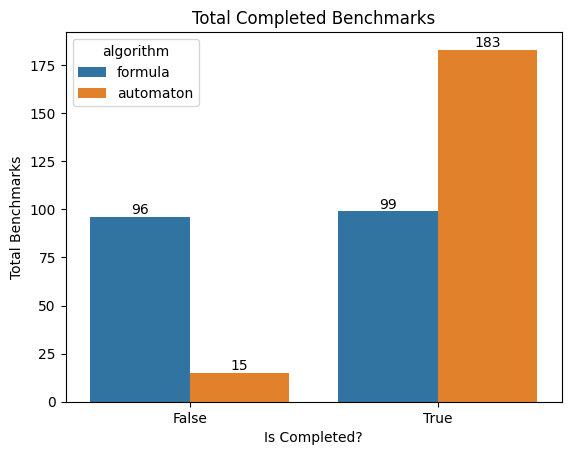

In [10]:
ax = sns.countplot(x="is_completed", data=shared_df, hue="algorithm");
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Completed Benchmarks");
ax.set(xlabel="Is Completed?", ylabel="Total Benchmarks");

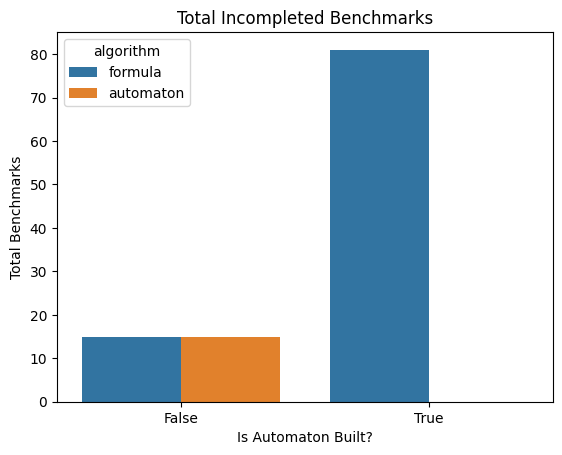

In [26]:
ax = sns.countplot(data=shared_df[shared_df["is_completed"] == False], x="is_automaton_built", hue="algorithm")
ax.set_title("Total Incompleted Benchmarks");
ax.set(xlabel="Is Automaton Built?", ylabel="Total Benchmarks");

### Comparing Dependencies

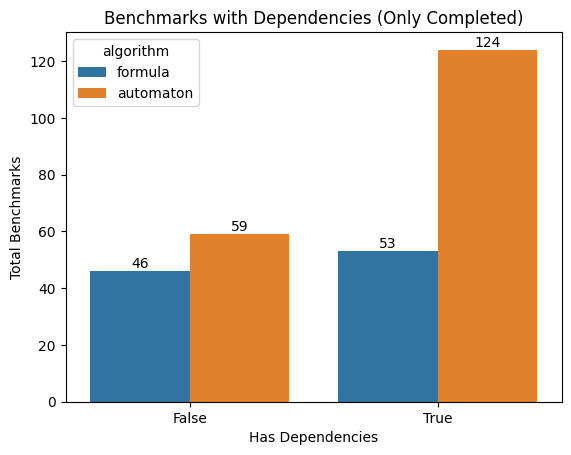

In [11]:
has_dependencies_df = shared_df[shared_df["is_completed"] == True].copy()
has_dependencies_df["has_deps"] = has_dependencies_df.apply(lambda x: x["total_dependent_vars"] > 0, axis=1)

ax = sns.countplot(x="has_deps", data=has_dependencies_df, hue="algorithm");
for container in ax.containers: ax.bar_label(container)
ax.set_title("Benchmarks with Dependencies (Only Completed)");
ax.set(xlabel="Has Dependencies", ylabel="Total Benchmarks");

# Dependency Algorithm

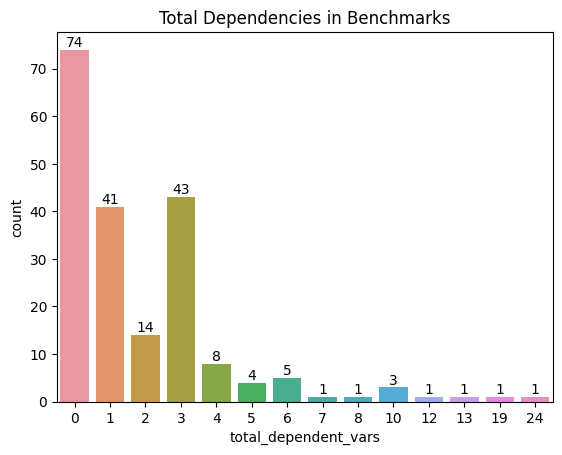

In [12]:
ax = sns.countplot(data=automaton_df, x="total_dependent_vars");
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Dependencies in Benchmarks");

In [13]:
ratios_df = automaton_df.copy()
ratios_df["dependency_ratio"] = ratios_df.apply(lambda x: x["total_dependent_vars"] / len(x["output_vars"]), axis=1)
ratios_df["deps_calc_duration_ratio"] = ratios_df.apply(lambda x: x["total_duration"] / x["automaton_build_duration"], axis=1)

**TODO:** Bin the ratios and visualte it

In [14]:
ratio_quantile = ratios_df["deps_calc_duration_ratio"].quantile(np.arange(0.1, 1, 0.1))
ratio_quantile

0.1    1.000000
0.2    1.000000
0.3    1.000773
0.4    1.002525
0.5    1.028226
0.6    1.041844
0.7    1.056190
0.8    1.083046
0.9    1.113651
Name: deps_calc_duration_ratio, dtype: float64

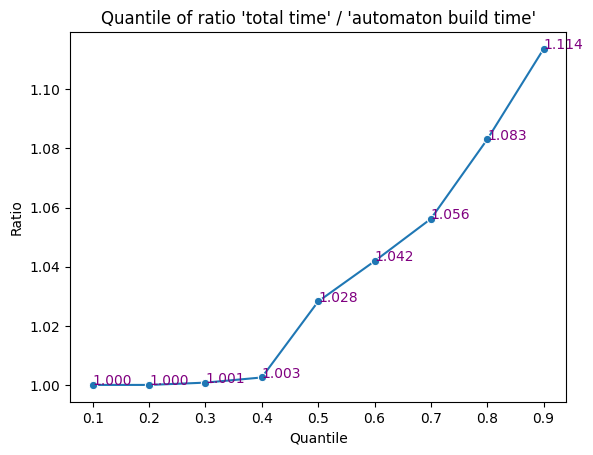

In [15]:
ax = sns.lineplot(ratio_quantile, marker="o");
ax.set_title("Quantile of ratio 'total time' / 'automaton build time'");
ax.set(xlabel="Quantile", ylabel="Ratio");

for key in ratio_quantile.keys():
    y=ratio_quantile[key]
    ax.text(x = key, y = y, color = 'purple', s= '{:.3f}'.format(y))

In [16]:
ratios_df.head()

,name,is_completed,total_duration,is_automaton_built,automaton_build_duration,automaton_total_states,automaton_state_based,dependent_vars,total_dependent_vars,independent_vars,...,total_tested_vars,total_untested_vars,output_vars,input_vars,formula,total_pair_states,search_pair_state_duration,pruned_state_based_status,dependency_ratio,deps_calc_duration_ratio
0,ltl2dpa20,True,35,True,33.0,14.0,true,[p0],1,[p1],...,2,0,"[p1, p0]","[c, b, a]",G((p0 & !p1) | (!p0 & p1)) & ((FG!p0 & (FG!a |...,27,0.0,true,0.500000,1.060606
1,TwoCountersInRangeA2,True,7735,True,7728.0,6.0,true,"[u0first2counter0first2counter, u0second2count...",3,"[u0first2counter0f1ddecrement0first2counter1b,...",...,8,0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",(!p0p0in2range0first2counter | !p0p0in2range0s...,12,0.0,true,0.375000,1.000906
2,lilydemo24,True,22,True,21.0,12.0,true,[],0,"[b2s_ack0, b2s_ack1, b2r_req0, b2r_req1]",...,4,0,"[b2r_req1, b2r_req0, b2s_ack1, b2s_ack0]","[r2b_ack1, r2b_ack0, s2b_req1, s2b_req0]",r2b_ack0 | F((!b2r_req0 & Xr2b_ack0) | (b2r_re...,22,0.0,true,0.000000,1.047619
3,OneCounterGuiA9,True,15428,True,15417.0,9.0,true,"[u0button2down0button2down, u0button2up0button...",3,"[u0button2down0f1ddisable1b, u0button2down0f1d...",...,9,0,"[u0counter0f1dinc0counter1b, u0counter0f1ddec0...","[p0p0in2range0f1dinc0f1dinc0counter1b1b, p0p0i...",(p0p0button2pressed0down | p0p0button2pressed0...,15,0.0,true,0.333333,1.000713
4,ltl2dba24,True,8,True,8.0,4.0,true,[],0,[acc],...,1,0,[acc],[p],(Fp & GFacc) | (G!p & FG!acc),7,0.0,true,0.000000,1.000000


In [19]:
ratios_df.dependency_ratio.describe()

count    198.000000
mean       0.274288
std        0.270908
min        0.000000
25%        0.000000
50%        0.333333
75%        0.375000
max        1.000000
Name: dependency_ratio, dtype: float64

In [20]:
ratios_df[ratios_df["total_dependent_vars"] > 0].dependency_ratio.describe()

count    124.000000
mean       0.437976
std        0.212770
min        0.153846
25%        0.333333
50%        0.369318
75%        0.500000
max        1.000000
Name: dependency_ratio, dtype: float64

# Results Summary

In [27]:
summary_df = ratios_df.copy()
summary_df["total_inputs"] = summary_df.apply(lambda x: len(x["input_vars"]), axis=1)
summary_df["total_outputs"] = summary_df.apply(lambda x: len(x["output_vars"]), axis=1)
summary_df["find deps duration"] = summary_df.apply(lambda x: x["total_duration"] - x["automaton_build_duration"], axis=1)
summary_df = summary_df[
    ["name", "total_inputs", "total_outputs", "is_completed", "automaton_build_duration", "is_automaton_built", "find deps duration",
     "total_dependent_vars","dependency_ratio"]
]
summary_df.rename(columns={
    'name': 'benchmark name',
    'automaton_build_duration': 'automaton build duration (ms)',
    "find deps duration": "find dependencies duration (ms)",
}, inplace=True)
summary_df.to_csv('./dependecies_summary.csv', sep=',', encoding='utf-8')
summary_df

,benchmark name,total_inputs,total_outputs,is_completed,automaton build duration (ms),is_automaton_built,find dependencies duration (ms),total_dependent_vars,dependency_ratio
0,ltl2dpa20,3,2,True,33.0,True,2.0,1,0.500000
1,TwoCountersInRangeA2,11,8,True,7728.0,True,7.0,3,0.375000
2,lilydemo24,4,4,True,21.0,True,1.0,0,0.000000
3,OneCounterGuiA9,9,9,True,15417.0,True,11.0,3,0.333333
4,ltl2dba24,1,1,True,8.0,True,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
193,KitchenTimerV8,4,11,False,NaN,False,NaN,0,0.000000
194,ltl2dba27,1,1,True,14.0,True,0.0,0,0.000000
195,TorcsGearing,1,3,True,13.0,True,0.0,1,0.333333
196,ltl2dpa19,3,3,True,116.0,True,4.0,1,0.333333
